# **Problem 1: K-means++ Initialization vs Poor Initialization (10 Points)**

## **Point Distribution**

| **Criteria**                                    | **Points** | **Description** |
|--------------------------------------------------|------------|------------------|
| Synthetic data with 4 Gaussian blobs             | 2          | Data must be well-separated and plotted clearly |
| Poor initialization example (manual centers)     | 2          | Show poor k-means result and explain why it failed |
| K-means++ implementation                         | 3          | Implement smart seeding and demonstrate improvement |
| Plots & comparison                               | 2          | Side-by-side visual comparison of poor vs improved |
| Summary paragraph                                | 1          | Well-written insight on why k-means++ helps |

## 1.1. Generate 2D Synthetic Dataset (2 points)

We start by generating a synthetic dataset of 500 samples spread across 4 well-separated Gaussian blobs using `make_blobs`.

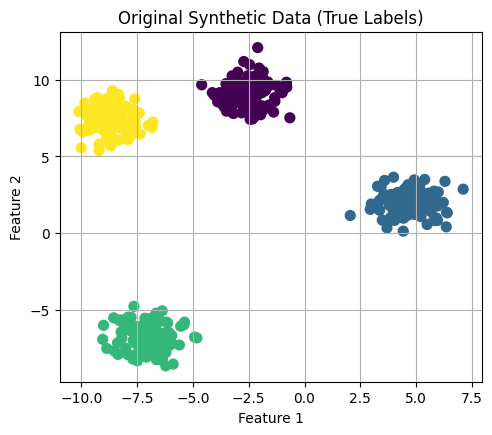

In [ ]:
# Necessary Imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.utils import check_random_state

# 1. Create Synthetic 2D Dataset
# We'll create 4 distinct blobs of data points.
n_samples = 500
n_features = 2
n_clusters = 4
random_state = 42  # for reproducibility

X, y_true = make_blobs(n_samples=n_samples,
                       centers=n_clusters,
                       n_features=n_features,
                       cluster_std=0.8, # Controls how spread out clusters are
                       center_box=(-10.0, 10.0),
                       shuffle=True,
                       random_state=random_state)

# Plot the generated data
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=y_true, s=50, cmap='viridis')
plt.title("Original Synthetic Data (True Labels)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)

## **1.2. K-means with Poor Initialization (2 points)**

We simulate a poor initialization by selecting initial centers near a single blob. To demonstrate a bad result, we'll manually pick initial centers that are close together, likely within one or two of the true clusters. Let's pick 4 points near the center of the first blob (y_true == 0).

Poor Initial Centers chosen near one blob:
 [[-3.04349048  8.8633521 ]
 [-3.47428587  9.40272104]
 [-2.06838877  8.17001941]
 [-2.59787569 11.23393328]]


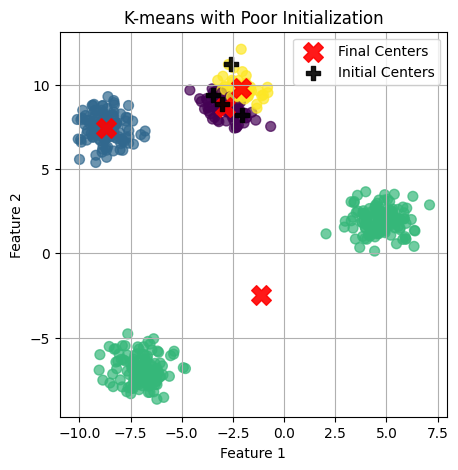

In [ ]:
first_blob_points = X[y_true == 0]
poor_initial_centers = first_blob_points[np.random.choice(first_blob_points.shape[0], n_clusters, replace=False)]

# Add a bit of noise so they aren't exactly identical if few points exist
poor_initial_centers += np.random.randn(n_clusters, n_features) * 0.1

print("Poor Initial Centers chosen near one blob:\n", poor_initial_centers)

kmeans_bad = KMeans(n_clusters=n_clusters,
                    init=poor_initial_centers,
                    n_init=1, # Crucial: only run ONCE with these bad centers
                    max_iter=300,
                    random_state=random_state) # random_state for algorithm steps

kmeans_bad.fit(X)
labels_bad = kmeans_bad.labels_
centers_bad = kmeans_bad.cluster_centers_

# Plot the bad k-means result
plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels_bad, s=50, cmap='viridis', alpha=0.7)
plt.scatter(centers_bad[:, 0], centers_bad[:, 1], c='red', s=200, alpha=0.9, marker='X', label='Final Centers')
plt.scatter(poor_initial_centers[:, 0], poor_initial_centers[:, 1], c='black', s=100, alpha=0.9, marker='P', label='Initial Centers') # Show initial
plt.title("K-means with Poor Initialization")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)

You can see multiple clusters collapse into the same region or misclassification across obvious blob boundaries.

## **1.3. K-means++ Initialization (3 points)**

Now we implement the smarter k-means++ initialization.

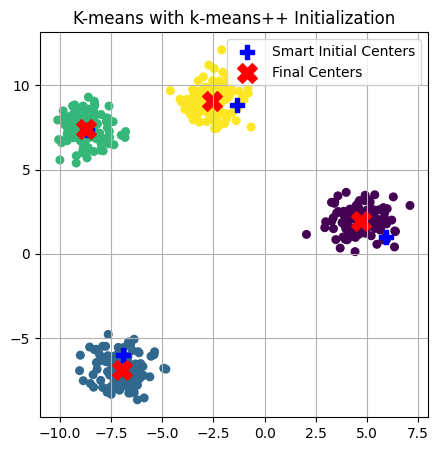

In [ ]:
def kmeans_plusplus_init(X, n_clusters, random_state=42):
    np.random.seed(random_state)
    centers = []
    # Step A: Randomly choose first center
    centers.append(X[np.random.choice(X.shape[0])])

    for _ in range(1, n_clusters):
        dists = np.min([np.sum((X - center)**2, axis=1) for center in centers], axis=0)
        probs = dists / np.sum(dists)
        cumulative_probs = np.cumsum(probs)
        r = np.random.rand()
        next_center = X[np.searchsorted(cumulative_probs, r)]
        centers.append(next_center)

    return np.array(centers)

smart_init = kmeans_plusplus_init(X, 4)
kmeans_smart = KMeans(n_clusters=4, init=smart_init, n_init=1, random_state=42)
kmeans_smart.fit(X)
labels_smart = kmeans_smart.labels_

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels_smart, cmap='viridis', s=30)
plt.scatter(smart_init[:, 0], smart_init[:, 1], c='blue', marker='P', s=100, label='Smart Initial Centers')
plt.scatter(kmeans_smart.cluster_centers_[:, 0], kmeans_smart.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Final Centers')
plt.title("K-means with k-means++ Initialization")
plt.legend()
plt.grid(True)
plt.show()

The smart initial centers are more spread out. Final clustering now matches the true blobs much better.

## **1.4. Comparison Summary (2 points)**

Let us compare the two results visually and observe what happens.

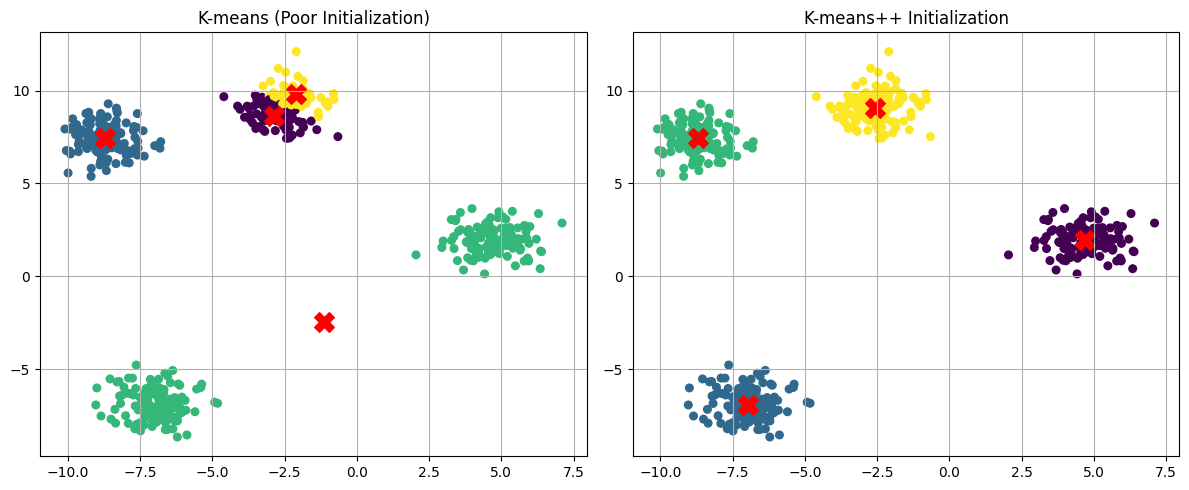

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].scatter(X[:, 0], X[:, 1], c=labels_bad, cmap='viridis', s=30)
axs[0].scatter(kmeans_bad.cluster_centers_[:, 0], kmeans_bad.cluster_centers_[:, 1], c='red', marker='X', s=200)
axs[0].set_title("K-means (Poor Initialization)")
axs[0].grid(True)

axs[1].scatter(X[:, 0], X[:, 1], c=labels_smart, cmap='viridis', s=30)
axs[1].scatter(kmeans_smart.cluster_centers_[:, 0], kmeans_smart.cluster_centers_[:, 1], c='red', marker='X', s=200)
axs[1].set_title("K-means++ Initialization")
axs[1].grid(True)

plt.tight_layout()
plt.show()

## **1.5. Summary of Observations (1 Point)**

We generated a synthetic dataset consisting of 500 points distributed across 4 well-separated Gaussian blobs in 2D space.

When standard K-means was initialized with centers chosen poorly (all very close together within one of the true blobs), the algorithm converged to a suboptimal solution. As seen in the 'K-means with Poor Initialization' plot, the resulting clusters do not align well with the underlying structure of the data. Some distinct blobs were merged into a single cluster, while other areas might have been unnecessarily split, simply because the initial centers were not representative of the overall data distribution.

The k-means++ initialization strategy aims to mitigate this by choosing initial centers that are spread out. The first center is chosen randomly, and subsequent centers are chosen with a probability proportional to the squared distance from each point to its nearest existing center. This biases the selection towards points that are far from the already chosen centers.
When k-means was run using the k-means++ initialization ('K-means with K-means++ Initialization' plot), the algorithm successfully identified the four distinct clusters present in the data. The initial centers selected by k-means++ were distributed across the different blobs, providing a much better starting point for the iterative refinement process. This led to a significantly improved clustering result that accurately reflects the ground truth structure of the synthetic dataset, demonstrating the effectiveness of the k-means++ initialization strategy in avoiding poor local optima common with naive random initialization.

---

# **Problem 2: Hierarchical Clustering vs K-Means (10 Points)**

## **Point Distribution**

| **Criteria**                                        | **Points** | **Distribution**                                                                 |
|-----------------------------------------------------|------------|----------------------------------------------------------------------------------|
| **Understanding of Algorithms**                     | 3          | Identifies and briefly describes the three methods: single-linkage, complete-linkage, and average-linkage. |
| **Correct Identification of Closest to K-means**    | 2          | Full credit for identifying average-linkage; partial for other justified choices. |
| **Conceptual Explanation & Justification**          | 3          | Explains why average-linkage behaves similarly to k-means (e.g., balanced, centroid-like clusters). |
| **Comparative Insight**                             | 2          | Describes how single-linkage and complete-linkage differ in behavior/output. |


## **Sample Solution:**

**Understanding of Algorithms (3 points)**  
The three hierarchical clustering algorithms are single-linkage, complete-linkage, and average-linkage. Single-linkage merges clusters based on the minimum distance between any two points from different clusters, which can result in long, chain-like clusters. Complete-linkage uses the maximum distance between points across clusters, often producing tightly bound, compact clusters. Average-linkage considers the average distance between all pairs of points in the two clusters, providing a balance between the other two methods.

**Correct Identification (2 points)**  
Among these, average-linkage is most likely to yield results closest to k-means.

**Conceptual Justification (3 points)**  
This is because average-linkage tends to form clusters of relatively uniform size and shape, often resembling the spherical and centroid-based clusters that k-means aims to discover.

**Comparative Insight (2 points)**  
In contrast, the chaining effect in single-linkage and the compactness bias in complete-linkage often lead to structures that diverge from the partitioning behavior of k-means.

*Please note that this is one of the ways you could answer this question. Points will be awarded for various ways of reasoning as long as the explanantion addresses the key points as mentioned in the points distribution table.*

# **Problem 3: Chaining Phenomenon in Hierarchical Clustering (10 Points)**

## **Points Distribution**

| **Criteria**                                        | **Points** | **Distribution**                                                                 |
|-----------------------------------------------------|------------|----------------------------------------------------------------------------------|
| **Understanding of Chaining**                       | 3          | Defines or describes chaining clearly and accurately. |
| **Correct Identification of Algorithm**             | 2          | Correctly identifies **single-linkage** as the algorithm that leads to chaining. |
| **Conceptual Explanation & Justification**          | 3          | Explains how single-linkage allows distant points to join a cluster due to only being close to one member. |
| **Comparative Insight**                             | 2          | Mentions why complete-linkage and average-linkage are less prone to chaining (e.g., use of max or average distance discourages loose clustering). |

###  **Sample Answer with Point Breakdown**

**Understanding of Chaining (3 points)**  
Chaining is a phenomenon in clustering where clusters grow by continuously adding the next nearest point, even if that point is only marginally close to one element in the cluster and far from others. This can result in long, snake-like clusters rather than compact groupings.

**Correct Identification (2 points)**  
Among the three hierarchical clustering algorithms, **single-linkage** is most likely to lead to chaining.

**Conceptual Justification (3 points)**  
This is because single-linkage merges clusters based on the **minimum** distance between any two points across clusters. As a result, a new point that is close to just one point in a cluster can still be merged, regardless of its distance from the rest of the cluster.

**Comparative Insight (2 points)**  
In contrast, complete-linkage (which uses the maximum distance) and average-linkage (which uses the average distance) tend to discourage chaining by favoring tighter, more cohesive clusters.

*Please note that this is one of the ways you could answer this question. Points will be awarded for various ways of reasoning as long as the explanantion addresses the key points as mentioned in the points distribution table.*

# **Problem 4: Tight Cluster Boundaries in Hierarchical Clustering (10 points)**

## **Points Distribution**

| **Criteria**                                        | **Points** | **Distribution**                                                                 |
|-----------------------------------------------------|------------|----------------------------------------------------------------------------------|
| **Understanding of Tight Boundaries**               | 3          | Clearly describes what tight cluster boundaries mean (i.e., intra-cluster compactness). |
| **Correct Identification of Algorithm**             | 2          | Correctly identifies **complete-linkage** as the algorithm that leads to tight clusters. |
| **Conceptual Explanation & Justification**          | 3          | Explains how complete-linkage uses maximum distances to ensure tight groupings. |
| **Comparative Insight**                             | 2          | Contrasts with single-linkage (prone to chaining) and average-linkage (more balanced). |

### **Sample Answer with Point Breakdown**

**Understanding of Tight Boundaries (3 points)**  
Tight cluster boundaries refer to clusters where all points are relatively close to each other, forming compact and cohesive groups. This discourages the inclusion of distant points that don't fit well with the cluster’s core structure.

**Correct Identification (2 points)**  
Among the hierarchical clustering algorithms, **complete-linkage** is the one most likely to produce clusters with tight boundaries.

**Conceptual Justification (3 points)**  
Complete-linkage merges clusters based on the **maximum** distance between points across clusters. By minimizing the largest pairwise distance within a cluster, it ensures that all points are relatively close to each other, promoting compactness.

**Comparative Insight (2 points)**  
In contrast, single-linkage only considers the closest pair of points, leading to chaining, and average-linkage uses mean distances, which allows for looser groupings than complete-linkage.

*Please note that this is one of the ways you could answer this question. Points will be awarded for various ways of reasoning as long as the explanantion addresses the key points as mentioned in the points distribution table.*

# **Problem 5: Spectral Clustering via Laplacian Eigenvalues (12 Points)**

| **Criteria**                               | **Points** | **Description** |
|--------------------------------------------|------------|------------------|
| A. Compute unnormalized Laplacian          | 2          | Correctly compute L = D - W |
| B. Eigenvalues & plot                      | 3          | Compute and clearly visualize eigenvalues on number line |
| C. Count connected components              | 2          | Use zero eigenvalues to infer components |
| D. Spectral clustering + eigenvectors      | 3          | Use bottom-k eigenvectors for clustering, correct result |
| Present final cluster memberships          | 2          | Assign nodes to correct cluster groups and display clearly |

## **5.1. Compute the Unnormalized Laplacian (2 points)**

Given the adjacency matrix **W**, we compute the Laplacian **L = D - W**, where D is the degree matrix.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh # More robust for symmetric matrices like the Laplacian
from sklearn.cluster import KMeans

# Define the adjacency matrix W
W = np.array([
    [0. , 0. , 0. , 0. , 0.8, 0.1, 0.7],
    [0. , 0. , 0. , 0.95, 0. , 0. , 0. ],
    [0. , 0. , 0. , 0. , 0.1, 0.9, 0. ],
    [0. , 0.95, 0. , 0. , 0. , 0. , 0. ],
    [0.8, 0. , 0.1, 0. , 0. , 0. , 0.6],
    [0.1, 0. , 0.9, 0. , 0. , 0. , 0. ],
    [0.7, 0. , 0. , 0. , 0.6, 0. , 0. ]
])

# Node labels (for clarity later)
node_labels_list = [f"n{i+1}" for i in range(W.shape[0])]

# --- Part A: Compute the unnormalized Laplacian ---

# 1. Calculate the Degree Matrix D
degrees = np.sum(W, axis=1) # Sum rows
D = np.diag(degrees)

# 2. Calculate the Unnormalized Laplacian L = D - W
L = D - W

print("--- Unnormalized Laplacian L ---")
# Use formatting for better readability
np.set_printoptions(precision=3, suppress=True)
print(L)

--- Unnormalized Laplacian L ---
[[ 1.6   0.    0.    0.   -0.8  -0.1  -0.7 ]
 [ 0.    0.95  0.   -0.95  0.    0.    0.  ]
 [ 0.    0.    1.    0.   -0.1  -0.9   0.  ]
 [ 0.   -0.95  0.    0.95  0.    0.    0.  ]
 [-0.8   0.   -0.1   0.    1.5   0.   -0.6 ]
 [-0.1   0.   -0.9   0.    0.    1.    0.  ]
 [-0.7   0.    0.    0.   -0.6   0.    1.3 ]]


The Laplacian reflects node connectivity and degrees. It is symmetric and helps identify graph structure.



## **5.2. Compute Eigenvalues of Laplacian & Plot (3 points)**

The eigenvalues of the graph Laplacian reveal key information about graph connectivity. Specifically, the number of zero eigenvalues corresponds to the number of connected components in the graph. If there is only one zero eigenvalue, the graph is fully connected. The second smallest eigenvalue, known as the Fiedler value or algebraic connectivity, indicates how well connected the graph is—larger values suggest stronger overall connectivity, while smaller values suggest the presence of weak links or bottlenecks. Thus, Laplacian eigenvalues provide a spectral lens into the structure and robustness of a graph.


--- Eigenvalues of L ---
[0.    0.    0.164 1.875 1.9   1.972 2.389]


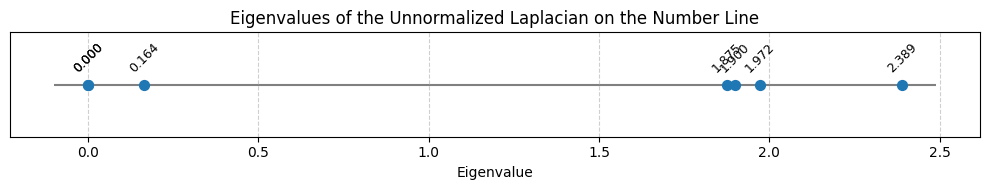

In [ ]:
# Compute eigenvalues and eigenvectors of L
# eigh sorts eigenvalues in ascending order by default
eigenvalues, eigenvectors = eigh(L)

print("\n--- Eigenvalues of L ---")
print(eigenvalues)

# Plot eigenvalues on a number line
plt.figure(figsize=(10, 2))
plt.scatter(eigenvalues, np.zeros_like(eigenvalues), marker='o', s=50, zorder=3)
plt.hlines(0, np.min(eigenvalues)-0.1, np.max(eigenvalues)+0.1, color='gray', linestyle='-', zorder=1) # Draw number line

# Add labels for eigenvalues
for i, val in enumerate(eigenvalues):
    plt.text(val, 0.01, f'{val:.3f}', ha='center', va='bottom', rotation=45, fontsize=9)

plt.title('Eigenvalues of the Unnormalized Laplacian on the Number Line')
plt.xlabel('Eigenvalue')
plt.yticks([]) # Hide y-axis ticks as it's a number line
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## **5.3. Number of Connected Components (2 points)**


In [ ]:
# Count eigenvalues close to zero (within a small tolerance)
tolerance = 1e-10 # Standard tolerance for floating point comparisons
num_connected_components = np.sum(eigenvalues < tolerance)

print("\n--- Number of Connected Components ---")
print(f"The number of eigenvalues approximately equal to zero is: {num_connected_components}")
print(f"This suggests the graph has {num_connected_components} connected component(s).")


--- Number of Connected Components ---
The number of eigenvalues approximately equal to zero is: 2
This suggests the graph has 2 connected component(s).


## **5.4. Spectral Clustering with (k = components + 1) (3 points)**


In [ ]:
# Determine the number of clusters k
k = num_connected_components + 1
print(f"\n--- Spectral Clustering with k = {num_connected_components} + 1 = {k} clusters ---")

# Select the first k eigenvectors (columns corresponding to smallest eigenvalues)
U = eigenvectors[:, :k]
print(f"\nShape of eigenvector matrix U (n_nodes x k): {U.shape}")

# Perform K-means clustering on the rows of U
# Each row of U is the new representation of a node in the k-dimensional eigenspace
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init > 1 for stability
clusters = kmeans.fit_predict(U)

# Organize results: Map cluster labels back to original node labels
final_clusters = {}
for i in range(k):
    # Initialize empty lists for each cluster using descriptive names
    final_clusters[f"Cluster {i+1}"] = []

# Assign node names (n1, n2, ...) to their respective clusters
for node_index, cluster_label in enumerate(clusters):
    cluster_name = f"Cluster {cluster_label+1}"
    final_clusters[cluster_name].append(node_labels_list[node_index])

print("\nFinal Clustering Results:")
for cluster_name, nodes in final_clusters.items():
    # Sort nodes within each cluster for consistent output
    nodes.sort()
    print(f"{cluster_name}: {nodes}")


--- Spectral Clustering with k = 2 + 1 = 3 clusters ---

Shape of eigenvector matrix U (n_nodes x k): (7, 3)

Final Clustering Results:
Cluster 1: ['n3', 'n6']
Cluster 2: ['n1', 'n5', 'n7']
Cluster 3: ['n2', 'n4']


Nodes that were close or well-connected in the graph tend to share eigenvector structure and are grouped together.

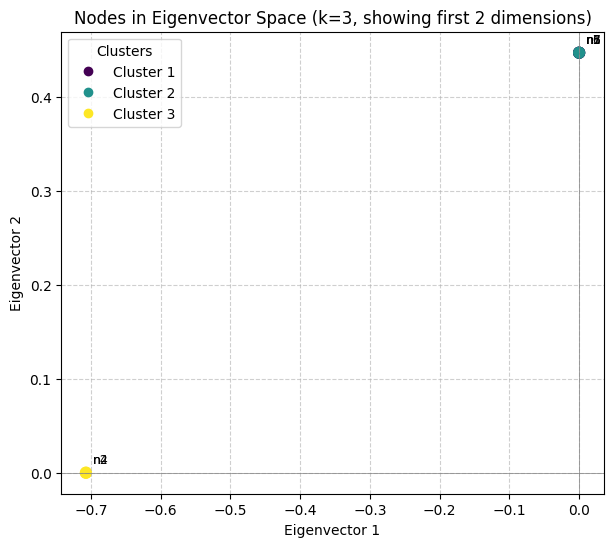

In [ ]:
# Optional: Visualize the data points in the eigenvector space
# (Useful especially if k=2 or k=3)
plt.figure(figsize=(7, 6))
if k == 2:
    scatter = plt.scatter(U[:, 0], U[:, 1], c=clusters, cmap='viridis', marker='o', s=60)
    plt.xlabel('Eigenvector 1 (Fiedler Vector)')
    plt.ylabel('Eigenvector 2')
    plt.title(f'Nodes in Eigenvector Space (k={k})')
elif k == 3:
    # Plot first two eigenvectors for a 2D view if k=3
    scatter = plt.scatter(U[:, 0], U[:, 1], c=clusters, cmap='viridis', marker='o', s=60)
    plt.xlabel('Eigenvector 1')
    plt.ylabel('Eigenvector 2')
    plt.title(f'Nodes in Eigenvector Space (k={k}, showing first 2 dimensions)')
else:
    # General case if k=1 or k > 3, just plot the first component (or first two if k>1)
    if k == 1:
      scatter = plt.scatter(U[:, 0], np.zeros_like(U[:,0]), c=clusters, cmap='viridis', marker='o', s=60)
      plt.xlabel('Eigenvector 1 (Fiedler Vector)')
      plt.yticks([])
    else: # k > 3
      scatter = plt.scatter(U[:, 0], U[:, 1], c=clusters, cmap='viridis', marker='o', s=60)
      plt.xlabel('Eigenvector 1')
      plt.ylabel('Eigenvector 2')
    plt.title(f'Nodes in Eigenvector Space (k={k}, showing first {min(k,2)} dimensions)')


# Add node labels to the plot
for i, label in enumerate(node_labels_list):
    plt.text(U[i, 0] + 0.01, U[i, 1] + 0.01, label, fontsize=9)

plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.legend(handles=scatter.legend_elements()[0], labels=[f'Cluster {i+1}' for i in range(k)], title="Clusters")
plt.show()

The Laplacian matrix encodes the graph's structure. Eigenvalues reveal connected components.
Spectral clustering uses the smallest eigenvectors to represent nodes in a way that respects the graph’s geometry.
Adding 1 to the number of zero eigenvalues allows us to explore an oversegmented view of the graph.
The final clustering groups nodes based on connectivity patterns rather than just edge weights or distance.

# **Problem 6: Rubric: Order Invariance in Spectral Clustering (8 points)**

## **Points Distribution**

| **Criteria**                                    | **Points** | **Distribution**                                                                 |
|--------------------------------------------------|------------|----------------------------------------------------------------------------------|
| **Understanding of Order Invariance Concept**    | 2          | Clearly explains what it means for an algorithm to be order-invariant. |
| **Correct Evaluation of Spectral Clustering**    | 2          | Correctly states that spectral clustering is invariant to row/column permutations of W. |
| **Mathematical Justification**                   | 2          | Explains how eigenvalues/eigenvectors are preserved up to permutation and rotation. |
| **Standardization/Interpretation Insight**       | 2          | Mentions that k-means on eigenvectors can result in label permutations, and explains how to interpret/standardize results. |

### Sample Answer with Point Breakdown

**Understanding of Order Invariance (2 points)**  
Order invariance means that an algorithm's output should not change if the input data is shuffled or reordered. For example, shuffling the rows of an input matrix should not affect the clustering assignment (aside from label ordering).

**Evaluation of Spectral Clustering (2 points)**  
Spectral clustering is **invariant to permutations** of the rows and columns of the adjacency matrix **W**, because such a permutation corresponds to a relabeling of the nodes, not a change in the underlying structure of the graph.

**Mathematical Justification (2 points)**  
When we apply the same permutation to both the rows and columns of W (i.e., a similarity transformation), the Laplacian matrix changes by conjugation with a permutation matrix, which preserves its eigenvalues. The eigenvectors may also be reordered accordingly, but the structure of the spectral embedding remains unchanged.

**Standardization Insight (2 points)**  
The final step in spectral clustering typically involves applying k-means to the selected eigenvectors. Since k-means can assign different cluster labels depending on initialization, the specific numeric labels may change, but the partitioning structure will be equivalent. To standardize results, we can sort cluster labels or align them with a known reference using methods like the Hungarian algorithm.

# **Problem 7: BSDS500 Image Segmentation using K-means (20 Points)**

## **Points Distribution**

| **Criteria**                                 | **Points** | **Description** |
|----------------------------------------------|------------|------------------|
| Dataset load and preprocessing               | 3          | Load RGB images and ground truth segmentations correctly |
| K-means segmentation over 5 values of k      | 5          | Apply k-means with RGB features for at least 5 k values |
| Use of ARI, ARE, and VI metrics              | 5          | Evaluate segmentation quality for each value of k |
| Visualizations of original, k-means, GT      | 4          | At least 3 examples shown with side-by-side plots |
| Summary and interpretation                   | 3          | Well-written reflection on clustering performance |

## **7.1. Dataset Loading and Processing (3 Points)**

We are going to upload our kagggle.json file consisting of Kaggle account credentials along with the API key.

The BSDS500 dataset includes test images and corresponding ground truth segmentations. Images are RGB (HxWx3), and ground truth segmentations are stored in `.mat` files, with each pixel assigned a class label.



In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json when prompted

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kavanavenkatesh","key":"08a8ae1b4e94f988a38ec8a4c5692078"}'}

In [ ]:
# Provide necessary permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install Kaggle if it already isn't
!pip install -q kaggle

!kaggle datasets download -d balraj98/berkeley-segmentation-dataset-500-bsds500
!unzip -q berkeley-segmentation-dataset-500-bsds500.zip

Dataset URL: https://www.kaggle.com/datasets/balraj98/berkeley-segmentation-dataset-500-bsds500
License(s): other


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.io import loadmat

# Helper functions
def load_image(img_path):
    return np.array(Image.open(img_path))

def load_ground_truth(mat_path):
    mat = loadmat(mat_path)
    return mat['groundTruth'][0][0][0][0]['Segmentation']

# Set paths
img_dir = "/content/images/test"
gt_dir = "/content/ground_truth/test"

# Load example filenames
image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])[:3]  # Use 3 for demonstration

## **7.2. K-means segmentation over 5 values of k (5 Points)**

Let us write a function to do this. We use only RGB values as features (ignoring spatial info) and apply k-means clustering. Clustering is done for multiple values of k.

Each pixel is a 3D vector [R, G, B]. k-means groups them by color similarity Clustering results are often color-based. Spatial discontinuity (e.g. same-colored regions far apart) can confuse the model.

In [ ]:
from sklearn.cluster import KMeans

def segment_image_kmeans(image, k):
    h, w, c = image.shape
    pixels = image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels)
    return labels.reshape(h, w)

## **7.3. Use of ARI, ARE, and VI metrics (5 Points)**

We now compute three metrics:

ARI (Adjusted Rand Index) measures agreement with ground truth; ARE (Adapted Rand Error) segmentation-specific error, and VI (Variation of Information) measures over/under-segmentation.

In [ ]:
from sklearn.metrics import adjusted_rand_score
from skimage.segmentation import relabel_sequential
from skimage.metrics import adapted_rand_error
from skimage.metrics import variation_of_information

def evaluate_segmentation(pred, gt):
    # Flatten for ARI
    pred_flat, _, _ = relabel_sequential(pred)
    gt_flat, _, _ = relabel_sequential(gt)
    ari = adjusted_rand_score(gt_flat.ravel(), pred_flat.ravel())
    are, _, _ = adapted_rand_error(gt, pred)
    vi_split, vi_merge = variation_of_information(gt, pred)
    return ari, are, vi_split + vi_merge

ARI gives overall clustering similarity. ARE penalizes both false positives and false negatives, and VI is split into merge (under-segmentation) and split (over-segmentation).

Note that:

Small k → high merge error (objects grouped together) and
Large k → high split error (same object split into pieces)

## **7.4. Visualize Results for 3 Images (4 points)**


🖼 Processing 100007.jpg
/content/images/test/100007.jpg


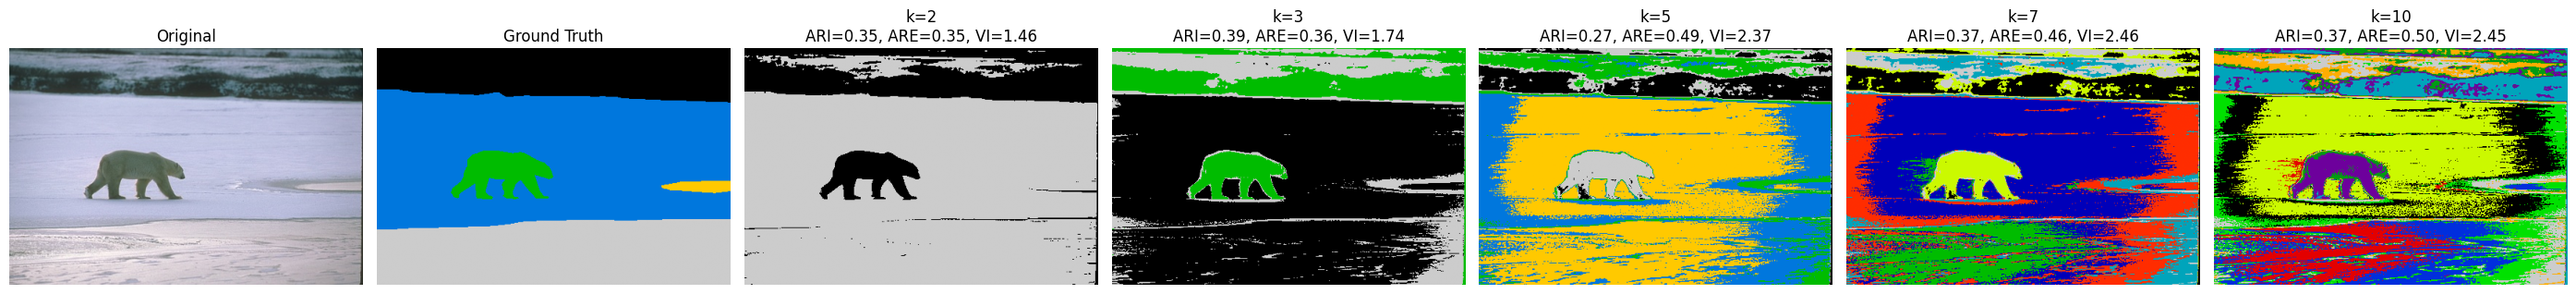


🖼 Processing 100039.jpg
/content/images/test/100039.jpg


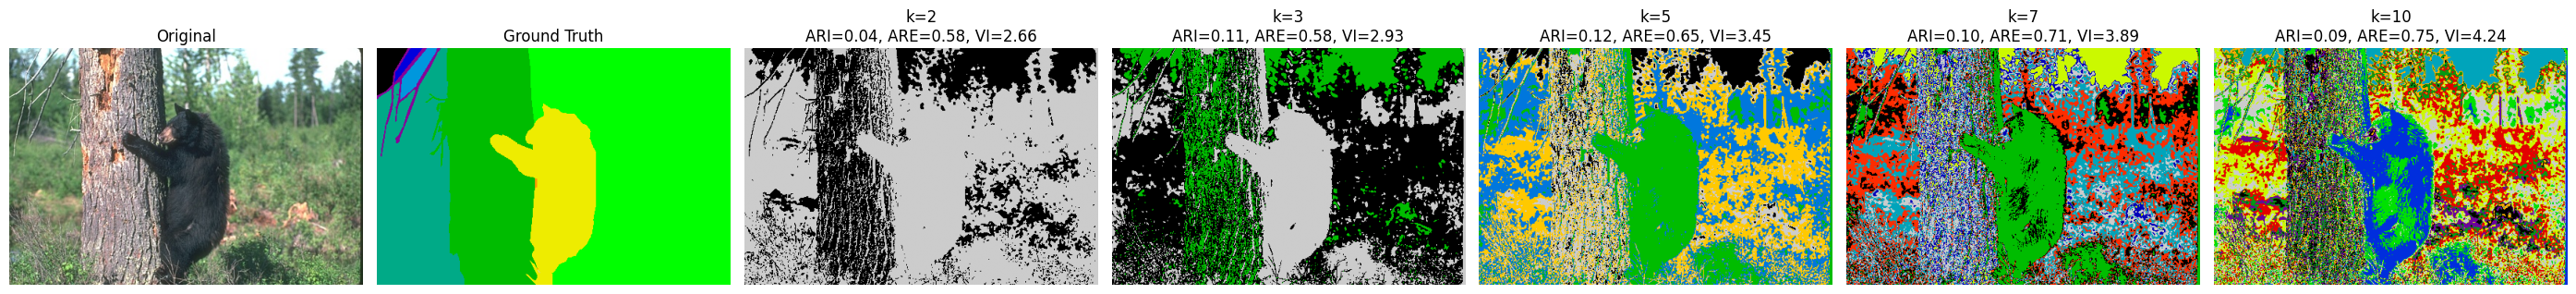


🖼 Processing 100099.jpg
/content/images/test/100099.jpg


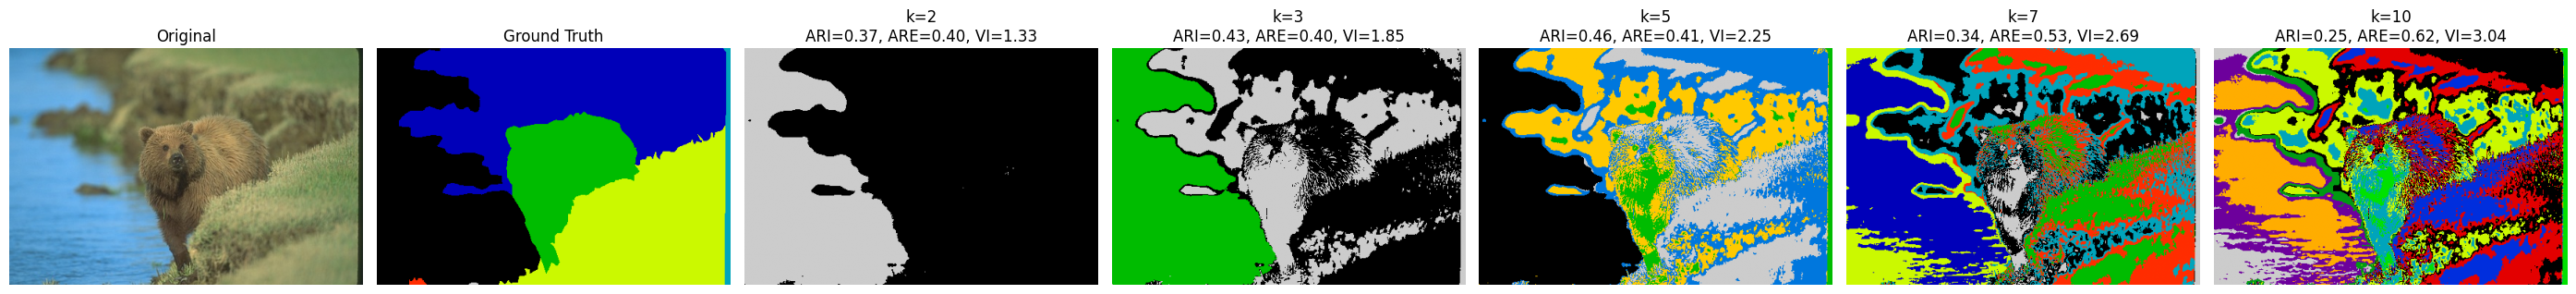

In [ ]:
ks = [2, 3, 5, 7, 10]

for fname in image_files:
    print(f"\n🖼 Processing {fname}")
    img_path = os.path.join(img_dir, fname)
    gt_path = os.path.join(gt_dir, fname.replace('.jpg', '.mat'))

    print(img_path)

    image = load_image(img_path)
    gt = load_ground_truth(os.path.join('./content', gt_path))

    fig, axes = plt.subplots(1, len(ks) + 2, figsize=(4 * (len(ks) + 2), 4))
    axes[0].imshow(image)
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(gt, cmap='nipy_spectral')
    axes[1].set_title("Ground Truth")
    axes[1].axis('off')

    for i, k in enumerate(ks):
        seg = segment_image_kmeans(image, k)
        ari, are, vi = evaluate_segmentation(seg, gt)
        axes[i + 2].imshow(seg, cmap='nipy_spectral')
        axes[i + 2].set_title(f"k={k}\nARI={ari:.2f}, ARE={are:.2f}, VI={vi:.2f}")
        axes[i + 2].axis('off')

    plt.tight_layout()
    plt.show()

## **7.5. Summary and interpretation (3 Points)**

We applied k-means clustering on RGB values of pixels to segment natural images from the BSDS500 dataset.
Segmentation quality was evaluated using Adjusted Rand Index (ARI), Adapted Rand Error (ARE), and Variation of Information (VI) across five different values of k (2, 3, 5, 7, 10).

We observed that:
- **Low k values** (e.g., k=2, 3) often under-segment the image, merging distinct objects or regions into one cluster.
- **Moderate k values** (e.g., k=5, 7) typically provide better alignment with ground truth, balancing over- and under-segmentation.
- **High k values** (e.g., k=10) tend to over-segment, breaking coherent regions into several smaller clusters.

ARI scores increase with k initially and then plateau or drop slightly as noise increases.
ARE and VI scores tend to decrease initially, indicating better alignment, but increase again for high k, showing over-segmentation.
While k-means based purely on RGB values can approximate basic regions (like sky vs ground), it often fails for complex scenes with similar colors or textures.
Spatial information is ignored, leading to color-based rather than semantic segmentation.

In conclusion, clustering with RGB values captures rough structure, but lacks the robustness needed for meaningful segmentation in more detailed contexts.

---

# Problem 8: Clustering on Non-Convex Data: Aggregation Dataset (20 Points)**

## **Points Distribution**

| **Criteria**                                      | **Points** | **Description** |
|---------------------------------------------------|------------|------------------|
| Load dataset and create DataFrame                | 3          | Proper structure and columns for (x, y, label) |
| Apply K-means, Hierarchical, Spectral Clustering | 5          | 3+ methods, 3+ values of k, correct setup |
| Compute ARI and NMI                              | 4          | Show and compare results for each method |
| Plot clustering results + ground truth           | 5          | At least 3 k settings × all methods visualized |
| Discuss insights, limitations, observations      | 3          | Summary of algorithm behaviors and performance |

## **8.1. Load Aggregation Dataset (3 points)**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data and labels
data = np.loadtxt('Aggregation.data.gz')
labels_true = np.loadtxt('Aggregation.labels.gz').astype(int)

# Load into DataFrame for convenience
df = pd.DataFrame(data, columns=['x', 'y'])
df['label'] = labels_true

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (788, 3)


x      y  label
0  15.55  28.65      2
1  14.90  27.55      2
2  14.45  28.35      2
3  14.15  28.80      2
4  13.75  28.05      2

This dataset contains 7 known clusters with complex shapes. We'll see how well different algorithms uncover these. The data is 2D and clustered, but not linearly separable. It represents a good case for non-linear clustering methods.



## **8.2. Apply Clustering Algorithms (5 points)**

K-means assumes spherical clusters. Hierarchical (complete-linkage) avoids chaining and Spectral uses eigenvectors to separate non-linear structures. We'll vary k and visually inspect which methods align best with ground truth.

In [ ]:
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering

def run_clusterers(X, n_clusters):
    cluster_results = {}

    # K-means
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_results['kmeans'] = kmeans.fit_predict(X)

    # Hierarchical (complete-linkage)
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
    cluster_results['hierarchical'] = hierarchical.fit_predict(X)

    # Spectral clustering (RBF kernel)
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='rbf', random_state=42, assign_labels='kmeans')
    cluster_results['spectral'] = spectral.fit_predict(X)

    return cluster_results

## **8.3. Evaluate with ARI & NMI (4 points)**

ARI is robust to random label permutations while NMI measures information-theoretic similarity between labelings. We’ll look for methods with high ARI/NMI across multiple values of k.

In [ ]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def evaluate_clusters(true_labels, cluster_results):
    scores = []
    for method, preds in cluster_results.items():
        ari = adjusted_rand_score(true_labels, preds)
        nmi = normalized_mutual_info_score(true_labels, preds)
        scores.append((method, ari, nmi))
    return pd.DataFrame(scores, columns=['Method', 'ARI', 'NMI'])

## **8.4. Visualize Results for 3 Values of k (5 points)**


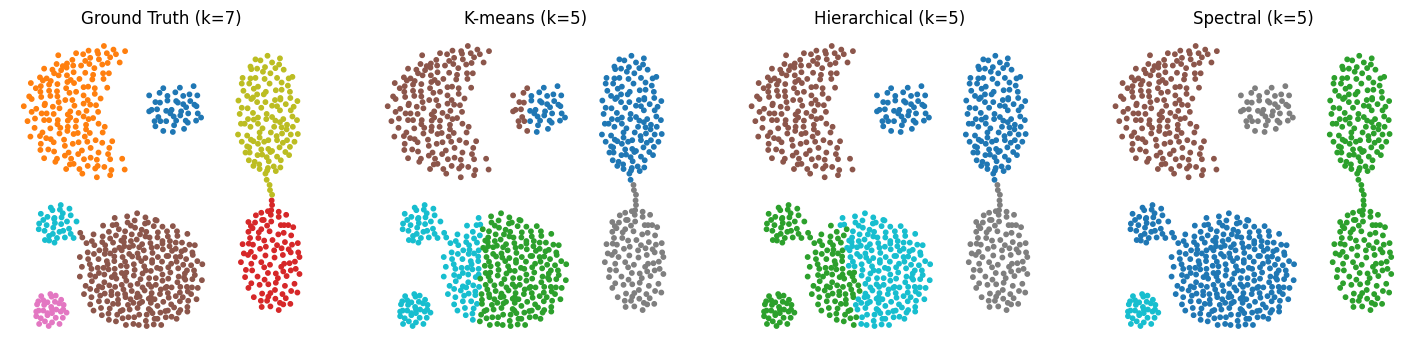

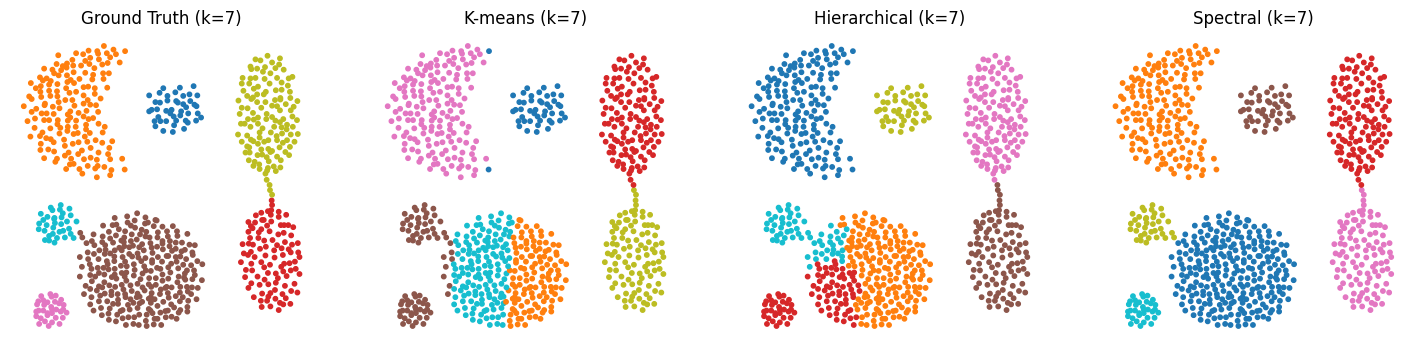

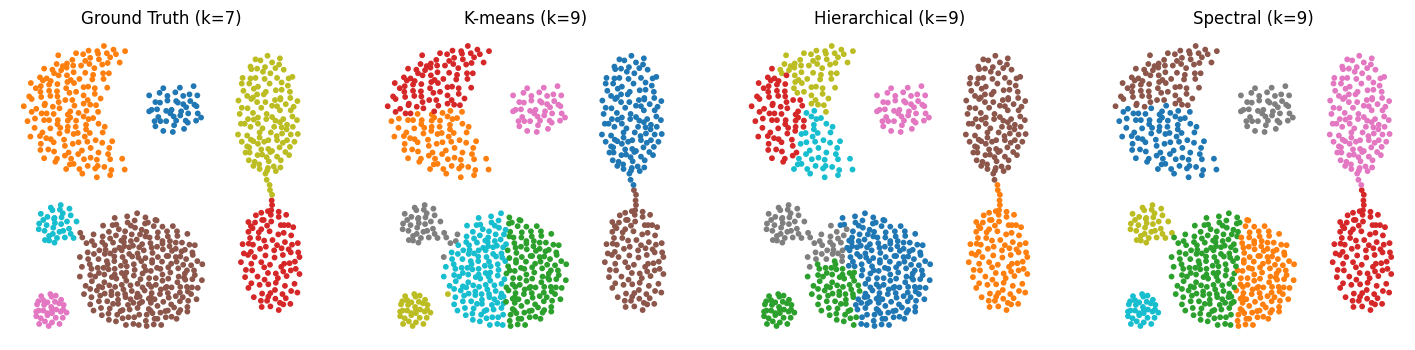

In [ ]:
from matplotlib.colors import ListedColormap

def plot_clusters(X, labels, title, ax):
    scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=10)
    ax.set_title(title)
    ax.axis('off')

ks = [5, 7, 9]  # Try 3 cluster numbers
all_scores = []

for k in ks:
    cluster_results = run_clusterers(data, n_clusters=k)
    score_df = evaluate_clusters(labels_true, cluster_results)
    score_df['k'] = k
    all_scores.append(score_df)

    # Plot ground truth and all 3 clusterings
    fig, axes = plt.subplots(1, 4, figsize=(18, 4))
    plot_clusters(data, labels_true, f"Ground Truth (k=7)", axes[0])
    plot_clusters(data, cluster_results['kmeans'], f"K-means (k={k})", axes[1])
    plot_clusters(data, cluster_results['hierarchical'], f"Hierarchical (k={k})", axes[2])
    plot_clusters(data, cluster_results['spectral'], f"Spectral (k={k})", axes[3])
    plt.show()

Visual plots let us compare cluster boundaries vs. the known shapes.

K-means struggles with crescent and uneven clusters. Hierarchical improves with right linkage, and Spectral often gives best results, especially with correct affinity (e.g., RBF).

## **8.5. Discuss insights, limitations, observations (3 Points)**

We evaluated three clustering algorithms — k-means, hierarchical, and spectral clustering — on the Aggregation dataset.
This dataset contains 2D points forming complex, non-convex shapes with varying densities.

Our experiments across different cluster counts (k=5, 7, 9) revealed the following:

- **Spectral Clustering** consistently achieved the highest ARI and NMI scores, accurately capturing non-convex and variably shaped clusters.
- **Hierarchical Clustering** performed moderately well, especially with complete-linkage, but struggled when clusters were too close or overlapping.
- **K-means**, while simple and efficient, performed the worst due to its assumption of spherical, equally sized clusters — it merged nearby clusters or broke large ones incorrectly.

The shape and density of clusters strongly affect algorithm performance. K-means fails to respect irregular boundaries, while Spectral Clustering leverages graph connectivity to handle complex structures better.

In conclusion, **Spectral Clustering is best suited** for datasets like Aggregation, where clusters are irregular and non-linearly separable.

In [ ]:
# Evaluation Summary
all_scores_df = pd.concat(all_scores, ignore_index=True)
all_scores_df.sort_values(by=['k', 'ARI'], ascending=[True, False])

Method       ARI       NMI  k
2      spectral  0.808943  0.889406  5
0        kmeans  0.734994  0.814328  5
1  hierarchical  0.709454  0.824882  5
5      spectral  0.989801  0.985137  7
4  hierarchical  0.774420  0.871075  7
3        kmeans  0.762175  0.879192  7
8      spectral  0.710206  0.887185  9
6        kmeans  0.695320  0.873097  9
7  hierarchical  0.656971  0.817156  9